# **Loading Data from Kaggle**

In [1]:
pip install kaggle

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [6]:
!mkdir data
!kaggle datasets download -d phylake1337/fire-dataset -p data --unzip


mkdir: cannot create directory ‘data’: File exists
Dataset URL: https://www.kaggle.com/datasets/phylake1337/fire-dataset
License(s): CC0-1.0
 94% 366M/387M [00:00<00:00, 610MB/s]
100% 387M/387M [00:00<00:00, 608MB/s]


# **Importing Libraries**

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import accuracy_score,precision_score,recall_score

# **Data Preprocessing**

**Before Adding Images**

In [8]:
fire = tf.keras.utils.image_dataset_from_directory(
    "data/fire_dataset",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)


Found 999 files belonging to 2 classes.


**After Adding Images**

In [5]:
fire = tf.keras.utils.image_dataset_from_directory(
    "data/fire_dataset",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)


Found 1034 files belonging to 2 classes.


In [6]:
class_names = fire.class_names
print(class_names)


['fire_images', 'non_fire_images']


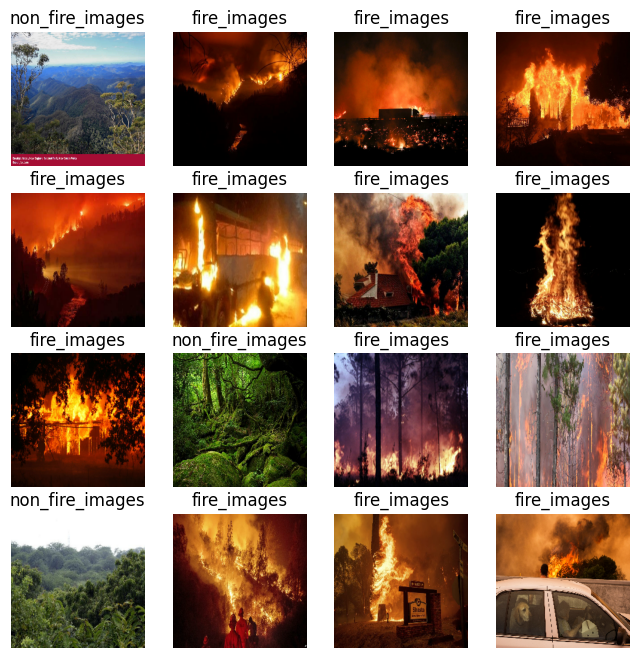

In [ ]:
plt.figure(figsize=(8, 8))

for images, labels in fire.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()



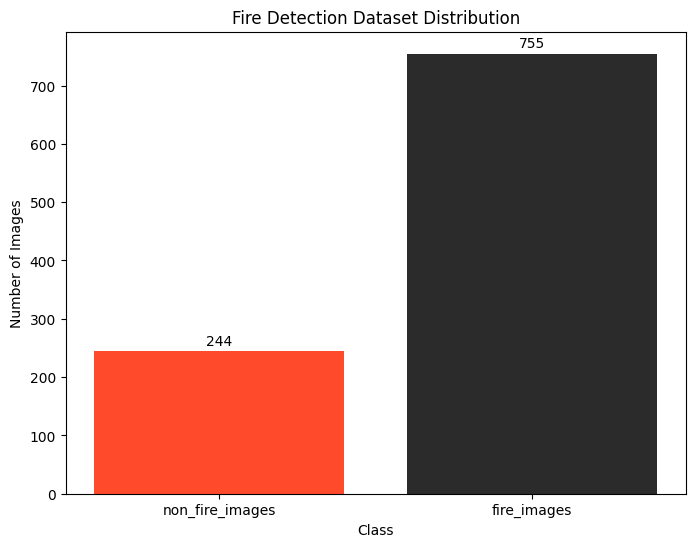

In [9]:
# 1. Get counts from folders
data_dir = "data/fire_dataset"
class_names = os.listdir(data_dir)
counts = [len(os.listdir(os.path.join(data_dir, name))) for name in class_names]

# 2. Create the Bar Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(class_names, counts, color=['#FF4B2B', '#2B2B2B']) # Red and Gray
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Fire Detection Dataset Distribution')

# Add number labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

plt.show()

**After Adding non fire images**

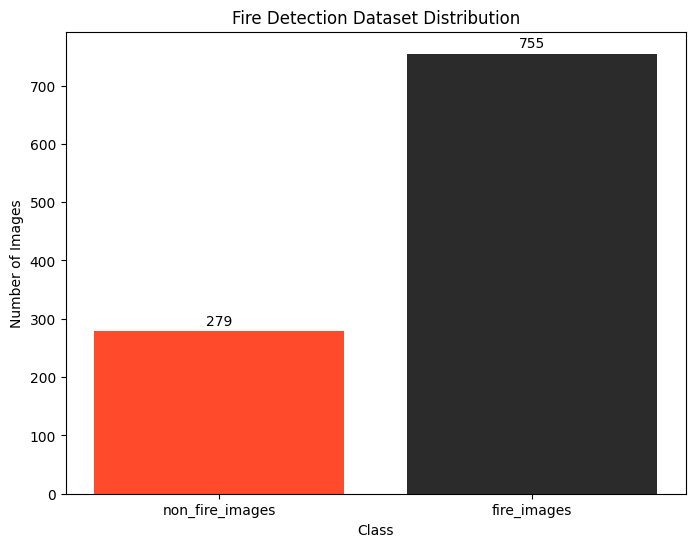

In [7]:
# 1. Get counts from folders
data_dir = "data/fire_dataset"
class_names = os.listdir(data_dir)
counts = [len(os.listdir(os.path.join(data_dir, name))) for name in class_names]

# 2. Create the Bar Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(class_names, counts, color=['#FF4B2B', '#2B2B2B']) # Red and Gray
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Fire Detection Dataset Distribution')

# Add number labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

plt.show()

## Data Splitting


Splitting the data for training, validating and testing

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "data/fire_dataset",
    validation_split=0.30,   # 30% goes to temp
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)


Found 1035 files belonging to 2 classes.
Using 725 files for training.


In [ ]:
temp_ds = tf.keras.utils.image_dataset_from_directory(
    "data/fire_dataset",
    validation_split=0.30,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)


Found 1035 files belonging to 2 classes.
Using 310 files for validation.


In [ ]:
val_size = int(0.5 * len(temp_ds))
test_size = len(temp_ds) - val_size

val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)


In [ ]:
print("Train batches:", len(train_ds))
print("Val batches:", len(val_ds))
print("Test batches:", len(test_ds))


Train batches: 23
Val batches: 5
Test batches: 5


## Normalisation

In [ ]:
train_ds = train_ds.map(lambda x, y: (x/255.0, y))
val_ds   = val_ds.map(lambda x, y: (x/255.0, y))
test_ds  = test_ds.map(lambda x, y: (x/255.0, y))


## Data Augmentation

Initial experiments with aggressive data augmentation (rotation, width/height shifts) resulted in a decrease in validation accuracy.

**Reasoning**: In fire detection, structural and color-specific features are critical. Excessive distortion introduced noise that hindered the model's ability to distinguish between fire and amber-hued ambient lighting.

**Action:** Augmentation was simplified/removed to maintain the integrity of the "Hard Negative" samples.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

normalization_layer = layers.Rescaling(1./255)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(normalization_layer(x)), y)
).prefetch(AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: (normalization_layer(x), y)
).prefetch(AUTOTUNE)

test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
).prefetch(AUTOTUNE)


# **Model Training**

## Model Training with Basic CNN Model

In [ ]:

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',      # watch validation loss
    patience=5,              # wait 3 epochs before stopping
    restore_best_weights=True
)


In [ ]:
checkpoint = ModelCheckpoint(
    filepath="best_fire_model.tf",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

In [ ]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop,checkpoint]
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.7099 - loss: 0.5901
Epoch 1: val_accuracy improved from -inf to 0.75625, saving model to best_fire_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 875ms/step - accuracy: 0.7116 - loss: 0.5896 - val_accuracy: 0.7563 - val_loss: 0.5607
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.7622 - loss: 0.5529
Epoch 2: val_accuracy did not improve from 0.75625
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 789ms/step - accuracy: 0.7624 - loss: 0.5525 - val_accuracy: 0.6812 - val_loss: 0.7762
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.7580 - loss: 0.5917
Epoch 3: val_accuracy did not improve from 0.75625
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 788ms/step - accuracy: 0.7585 - loss: 0.5901 - val_accuracy: 0.7437 - val_loss: 0.5645
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.7576 - loss: 0.5553
Epoch 4: val_accuracy did not improve from 0.75625
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 768ms/step - accuracy: 0.7581 - loss: 0.5545 - val_accuracy: 0.7375 - val_loss: 0.5505
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.7759 - loss: 0.4817
Epoch 5: val_accuracy did not i

22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 816ms/step - accuracy: 0.8230 - loss: 0.3218 - val_accuracy: 0.9125 - val_loss: 0.3068
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.9111 - loss: 0.3130
Epoch 8: val_accuracy did not improve from 0.91250
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 695ms/step - accuracy: 0.9088 - loss: 0.3141 - val_accuracy: 0.7188 - val_loss: 0.3386
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8234 - loss: 0.2862
Epoch 9: val_accuracy did not improve from 0.91250
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 673ms/step - accuracy: 0.8259 - loss: 0.2860 - val_accuracy: 0.9000 - val_loss: 0.2960
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9347 - loss: 0.2779
Epoch 10: val_accuracy did not improve from 0.91250
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 713ms/step - accuracy: 0.9344 - loss: 0.2771 - val_accuracy: 0.8875 - val_loss: 0.2693
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.8893 - loss: 0.2738
Epoch 11: val_accuracy did n

22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 751ms/step - accuracy: 0.8817 - loss: 0.3691 - val_accuracy: 0.9187 - val_loss: 0.2508
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9254 - loss: 0.2160
Epoch 19: val_accuracy did not improve from 0.91875
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 710ms/step - accuracy: 0.9251 - loss: 0.2163 - val_accuracy: 0.8875 - val_loss: 0.2225
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.9193 - loss: 0.2354
Epoch 20: val_accuracy did not improve from 0.91875
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 714ms/step - accuracy: 0.9194 - loss: 0.2353 - val_accuracy: 0.9062 - val_loss: 0.2106
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9311 - loss: 0.1754
Epoch 21: val_accuracy did not improve from 0.91875
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 705ms/step - accuracy: 0.9311 - loss: 0.1755 - val_accuracy: 0.8938 - val_loss: 0.2219
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9365 - loss: 0.1812
Epoch 22: val_accuracy d

22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 742ms/step - accuracy: 0.9225 - loss: 0.1894 - val_accuracy: 0.9500 - val_loss: 0.1562
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.9223 - loss: 0.1817
Epoch 25: val_accuracy did not improve from 0.95000
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 740ms/step - accuracy: 0.9227 - loss: 0.1812 - val_accuracy: 0.9125 - val_loss: 0.2241
Epoch 26/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9452 - loss: 0.1603
Epoch 26: val_accuracy did not improve from 0.95000
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 781ms/step - accuracy: 0.9451 - loss: 0.1609 - val_accuracy: 0.9187 - val_loss: 0.1893
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9122 - loss: 0.2223
Epoch 27: val_accuracy did not improve from 0.95000
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 731ms/step - accuracy: 0.9131 - loss: 0.2212 - val_accuracy: 0.8750 - val_loss: 0.2876
Epoch 28/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9281 - loss: 0.2054
Epoch 28: val_accuracy d

## Training with Data Augmentation

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop,checkpoint]
)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9397 - loss: 0.1605
Epoch 1: val_accuracy did not improve from 0.95000
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 748ms/step - accuracy: 0.9399 - loss: 0.1604 - val_accuracy: 0.9125 - val_loss: 0.2116
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.9557 - loss: 0.1358
Epoch 2: val_accuracy did not improve from 0.95000
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 717ms/step - accuracy: 0.9548 - loss: 0.1370 - val_accuracy: 0.8750 - val_loss: 0.2610
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9472 - loss: 0.1772
Epoch 3: val_accuracy did not improve from 0.95000
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 752ms/step - accuracy: 0.9473 - loss: 0.1765 - val_accuracy: 0.9000 - val_loss: 0.2505
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9416 - loss: 0.1684
Epoch 4: val_accuracy did not improve from 0.95000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 714ms/step - accuracy: 0.9414 - loss: 0.1690 - val_accuracy: 0.8687

## Model Training with MobileNetV2


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # freeze pretrained weights


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model1 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',      # watch validation loss
    patience=10,              # wait 3 epochs before stopping
    restore_best_weights=True
)


In [ ]:
checkpoint = ModelCheckpoint(
    filepath="best_fire_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)


In [ ]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop,checkpoint]
)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6322 - loss: 0.7079
Epoch 1: val_accuracy improved from -inf to 0.68125, saving model to best_fire_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.6344 - loss: 0.7049 - val_accuracy: 0.6812 - val_loss: 0.5251
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8071 - loss: 0.4197
Epoch 2: val_accuracy improved from 0.68125 to 0.85625, saving model to best_fire_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8074 - loss: 0.4193 - val_accuracy: 0.8562 - val_loss: 0.3243
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8690 - loss: 0.3295
Epoch 3: val_accuracy improved from 0.85625 to 0.86875, saving model to best_fire_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8693 - loss: 0.3291 - val_accuracy: 0.8687 - val_loss: 0.2490
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9044 - loss: 0.2536
Epoch 4: val_accuracy improved from 0.86875 to 0.91875, saving model to best_fire_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9046 - loss: 0.2535 - val_accuracy: 0.9187 - val_loss: 0.2046
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9009 - loss: 0.2312
Epoch 5: val_accuracy improved from 0.91875 to 0.93750, saving model to best_fire_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9012 - loss: 0.2312 - val_accuracy: 0.9375 - val_loss: 0.1451
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9252 - loss: 0.1969
Epoch 6: val_accuracy did not improve from 0.93750
23/23 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9253 - loss: 0.1961 - val_accuracy: 0.9125 - val_loss: 0.2030
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9230 - loss: 0.2002
Epoch 7: val_accuracy did not improve from 0.93750
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9238 - loss: 0.1989 - val_accuracy: 0.9187 - val_loss: 0.1908
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9395 - loss: 0.1666
Epoch 8: val_accuracy improved from 0.93750 to 0.94375, saving model to best_fire_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9398 - loss: 0.1657 - val_accuracy: 0.9438 - val_loss: 0.1154
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9395 - loss: 0.1470
Epoch 9: val_accuracy improved from 0.94375 to 0.96250, saving model to best_fire_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9398 - loss: 0.1465 - val_accuracy: 0.9625 - val_loss: 0.1500
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9295 - loss: 0.1979
Epoch 10: val_accuracy improved from 0.96250 to 0.97500, saving model to best_fire_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.9305 - loss: 0.1952 - val_accuracy: 0.9750 - val_loss: 0.1238
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9553 - loss: 0.1156
Epoch 11: val_accuracy did not improve from 0.97500
23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9553 - loss: 0.1154 - val_accuracy: 0.9625 - val_loss: 0.1225
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9710 - loss: 0.1116
Epoch 12: val_accuracy did not improve from 0.97500
23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9709 - loss: 0.1112 - val_accuracy: 0.9500 - val_loss: 0.1301
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9784 - loss: 0.0907
Epoch 13: val_accuracy did not improve from 0.97500
23/23 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9785 - loss: 0.0904 - val_accuracy: 0.9688 - val_loss: 0.0680
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9590 - loss: 0.1135
Epoch 14: val_accuracy did not improve from 0.97

23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9810 - loss: 0.0704 - val_accuracy: 0.9812 - val_loss: 0.0538
Epoch 23/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9887 - loss: 0.0442
Epoch 23: val_accuracy did not improve from 0.98125
23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9887 - loss: 0.0442 - val_accuracy: 0.9563 - val_loss: 0.1155
Epoch 24/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9865 - loss: 0.0598
Epoch 24: val_accuracy did not improve from 0.98125
23/23 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9866 - loss: 0.0591 - val_accuracy: 0.9688 - val_loss: 0.1429
Epoch 25/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9842 - loss: 0.0461
Epoch 25: val_accuracy did not improve from 0.98125
23/23 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9843 - loss: 0.0459 - val_accuracy: 0.9563 - val_loss: 0.1043
Epoch 26/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9835 - loss: 0.0722
Epoch 26: val_accuracy did not improve from 0.98

## Fine Tuning

In [ ]:
len(base_model.layers)


154

In [ ]:
fine_tune_at = 145   # unfreeze from here

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True


In [ ]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-7),  # smaller LR
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history2 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7737 - loss: 0.5839
Epoch 1: val_accuracy did not improve from 0.98125
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.7756 - loss: 0.5783 - val_accuracy: 0.9563 - val_loss: 0.1114
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7762 - loss: 0.5312
Epoch 2: val_accuracy did not improve from 0.98125
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7776 - loss: 0.5285 - val_accuracy: 0.9625 - val_loss: 0.1074
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8003 - loss: 0.4682
Epoch 3: val_accuracy did not improve from 0.98125
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8009 - loss: 0.4666 - val_accuracy: 0.9688 - val_loss: 0.0923
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7777 - loss: 0.5352
Epoch 4: val_accuracy did not improve from 0.98125
23/23 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7786 - loss: 0.5326 - val_accuracy: 0.9750 - val_loss: 0.0822
Epoc

## Data Leakage Verification  

In [ ]:
train_acc = model1.evaluate(train_ds)
val_acc   = model1.evaluate(val_ds)
print(train_acc, val_acc)


23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9898 - loss: 0.0437
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9510 - loss: 0.1157
[0.029781941324472427, 0.9958563446998596] [0.10363887250423431, 0.9624999761581421]


# **Model Evaluation**

## Evaluation Functions

**Accuracy Curve**
'

Function to find relation between Training accuracy and Validation accuracy

In [ ]:
def accuracy_curve(history):
  plt.figure(figsize=(6,4))
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Training vs Validation Accuracy')
  plt.show()

**Loss Curve**

Function to find the relation between Training loss and Validation loss

In [ ]:
def loss_curve(history):
  plt.figure(figsize=(6,4))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training vs Validation Loss')
  plt.show()

## Evalution of basic model

In [ ]:
best_model = tf.keras.models.load_model("best_fire_model.h5")
test_loss, test_acc = best_model.evaluate(test_ds)
print("Test Accuracy:", test_acc)



5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9715 - loss: 0.1170
Test Accuracy: 0.9731543660163879


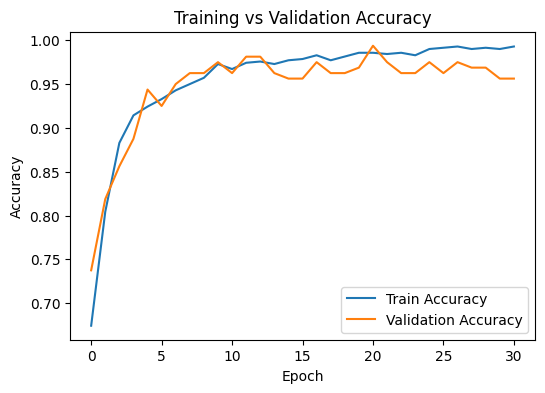

In [ ]:
accuracy_curve(history1)

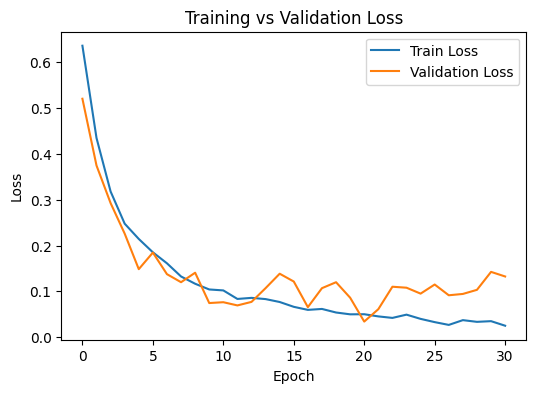

In [ ]:
loss_curve(history1)

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.23).astype(int).flatten())

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[106   1]
 [  1  41]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       107
           1       0.98      0.98      0.98        42

    accuracy                           0.99       149
   macro avg       0.98      0.98      0.98       149
weighted avg       0.99      0.99      0.99       149



In [ ]:

acc=accuracy_score(y_true,y_pred)
pre=precision_score(y_true,y_pred)
re=recall_score(y_true,y_pred)
print(acc)
print(pre)
print(re)

0.9865771812080537
0.9761904761904762
0.9761904761904762
